In [3]:
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
import pandas as pd
import os
import copy
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append(f'{ROOT_DIR}/code/helper')
import pipeline as pp
import trainers as tr
import process_results as pr
import data_preprocessing as dp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
importlib.reload(pp)
importlib.reload(dp)
importlib.reload(pr)
importlib.reload(tr)
import pickle
from multiprocessing import Pool
from torch.optim.lr_scheduler import ExponentialLR
from sklearn import metrics
from scipy.stats import bootstrap
from torchvision import models
from unet import UNet
import torch.nn.functional as F
from sklearn.utils import resample
import nibabel as nib
import torchio as tio
from torch.utils.data  import DataLoader, random_split, TensorDataset, Dataset
from torch.nn.modules.loss import _Loss

In [4]:
LONG = ['EMNIST', 'CIFAR', 'ISIC']
CLASS_ADJUST = ['EMNIST', 'CIFAR']
TENSOR = ['IXITiny']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def get_metric(metric_name):
    metric_mapping = {
        'EMNIST': metrics.accuracy_score,
        'CIFAR': metrics.accuracy_score,
        'IXITiny': get_dice_score,
        'ISIC': metrics.balanced_accuracy_score}
    return metric_mapping[metric_name]

In [6]:
def runModel(DATASET, c, n, architecture):
    X1, y1 = loadData(DATASET, 1, c)
    X2, y2 = loadData(DATASET, 2, c)

    dataloader = dp.DataPreprocessor(DATASET, BATCH_SIZE)
    global CLASSES
    if architecture == 'single':
        train_loader, val_loader, test_loader = dataloader.preprocess(X1, y1)
        if DATASET in CLASS_ADJUST:
            with open(f'{DATA_DIR}/CLASSES', 'rb') as f:
                classes_used = pickle.load(f)

            CLASSES = len(classes_used[c][0])
    elif architecture == 'joint':
        train_loader, val_loader, test_loader = dataloader.preprocess_joint(X1, y1, X2, y2)
        if DATASET in CLASS_ADJUST:
            with open(f'{DATA_DIR}/CLASSES', 'rb') as f:
                classes_used = pickle.load(f)
            CLASSES = len(set(classes_used[c][0] + classes_used[c][1]))

    model, criterion, optimizer, lr_scheduler = createModel(n)
    # Training hyperparameters
    PATIENCE = 5 
    
    # Train loop
    train_losses = []
    val_losses = []
    early_stop = False
    best_loss = float('inf')
    best_model = None

    for epoch in range(EPOCHS):

        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            model.zero_grad()
            outputs = model(x)
            if DATASET in LONG:
                y = y.long()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            train_loss += loss.item() 
        train_loss /= len(train_loader)
        # Validation
        model.eval() 
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                outputs = model(x)
                if DATASET in LONG:
                    y = y.long()
                loss = criterion(outputs, y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        # Log
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early stopping
        N = 5
        moving_avg_val_loss = sum(val_losses[-N:]) / N
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0 
            best_model = copy.deepcopy(model)
        else:
            if val_loss > moving_avg_val_loss:
                counter += 1
                if counter >= PATIENCE:
                    early_stop = True
                    break


    #Test
    test_loss = 0
    best_model.eval()
    with torch.no_grad():
        predictions_list = []
        true_labels_list = []
        test_loss = 0
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            predictions = best_model(X)
            if DATASET in LONG:
                y = y.long()
            loss = criterion(predictions, y)
            test_loss += loss.item()
            
            # Storing the predictions and true labels
            predictions_list.extend(predictions.cpu().numpy())
            true_labels_list.extend(y.cpu().numpy())

        test_loss /= len(test_loader)
        # Converting the lists to numpy arrays
        predictions_array = np.array(predictions_list)
        true_labels_array = np.array(true_labels_list)
        # Calculating the AUC
        metric_assess = get_metric(DATASET)
        if DATASET in TENSOR:
            score = metric_assess(torch.tensor(true_labels_array, dtype=torch.float32), torch.tensor(predictions_array,dtype=torch.float32))
        else:
            if DATASET in LONG:
                predictions_array = predictions_array.argmax(axis = 1) 
        score = metric_assess(true_labels_array, predictions_array)
    return best_model, score, train_losses, val_losses, test_loss

In [7]:
def modelRuns(DATASET, c, n, architecture):
    scores = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    for run in range(RUNS):
        best_model, score, train_losses, val_losses, test_loss = runModel(DATASET, c, n, architecture)
        scores.append(score)
        train_loss_list.append(train_losses)
        val_loss_list.append(val_losses)
        test_loss_list.append(test_loss)
    return scores, train_loss_list, val_loss_list, test_loss_list

In [8]:
def bootstrap_ci(data, alpha=0.95):
    median = np.median(data)
    bs_reps = bootstrap(np.array(data).reshape(1,-1), statistic=np.mean, n_resamples=1000)
    ci = bs_reps.confidence_interval[0:2]
    return median, ci[0], ci[1]

In [9]:
def runAnalysis(DATASET, costs, n):
    results_scores = {}
    results_train_losses = {}
    results_val_losses = {}
    for c in costs:
        results_scores[c] = {}
        results_train_losses[c] = {}
        results_val_losses[c] = {}
        for architecture in ['single', 'joint']:
            scores, train_loss_list, val_loss_list, test_loss_list = modelRuns(DATASET, c, n, architecture)
            results_scores[c][architecture] = scores
            results_train_losses[c][architecture] = train_loss_list
            results_val_losses[c][architecture] = val_loss_list

    with open(f'{ROOT_DIR}/results/{DATASET}_scores.pkl', 'wb') as f:
        pickle.dump(results_scores, f)
    
    with open(f'{ROOT_DIR}/results/{DATASET}_train_losses.pkl', 'wb') as f:
        pickle.dump(results_train_losses, f)

    with open(f'{ROOT_DIR}/results/{DATASET}_val_losses.pkl', 'wb') as f:
        pickle.dump(results_val_losses, f)

    return results_scores, results_train_losses, results_val_losses

In [10]:
def plotter(auc_scores,train_loss_list, val_loss_list, test_loss_list, data_type):    
    # Plotting Train Losses
    plt.figure(figsize = (5,3))
    # Determine the maximum length
    train_loss_list = [t[5:] for t in train_loss_list]
    val_loss_list = [v[5:] for v in val_loss_list]
    max_length = max(max(len(t) for t in train_loss_list), max(len(v) for v in val_loss_list))
    # Pad the shorter lists with np.nan
    train_losses_padded = [np.pad(t, (0, max_length - len(t)), 'constant', constant_values=np.nan) for t in train_loss_list]
    val_losses_padded = [np.pad(v, (0, max_length - len(v)), 'constant', constant_values=np.nan) for v in val_loss_list]
    train_losses = pd.DataFrame(train_losses_padded)
    val_losses = pd.DataFrame(val_losses_padded)
    sns.lineplot(train_losses.mean(axis = 0), label = 'Train', alpha = 0.5)
    sns.lineplot(val_losses.mean(axis = 0), label = 'Val', alpha = 0.5)
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return



## EMNIST

In [59]:
class LeNet5(nn.Module):
    def __init__(self, CLASSES):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(256, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, CLASSES)
        self.softmax = torch.nn.Softmax(dim = 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
        
def createModel(n):
    model = LeNet5(CLASSES)
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.9)
    return model, criterion, optimizer, lr_scheduler

In [60]:
def sample_per_class(labels, class_size = 500):
  df = pd.DataFrame({'labels': labels})
  df_stratified = df.groupby('labels').apply(lambda x: x.sample(class_size, replace=False))
  ind = df_stratified.index.get_level_values(1)
  return ind

def loadData(n, dataset, cost):
    ##load data
    data = np.load(f'{ROOT_DIR}/data/{DATASET}/data_{dataset}_{cost:.2f}.npz')
    ##get X and label
    X = data['data']
    y = data['labels']
    class_size = 100
    ind = sample_per_class(y, class_size)
    X_sample =  X[ind]
    y_sample = y[ind]

    unique_labels = np.unique(y_sample)
    mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_sample_mapped = np.vectorize(mapping.get)(y_sample)
        
    return X_sample, y_sample_mapped

In [61]:
DATA_DIR = f'{ROOT_DIR}/data/EMNIST'
EPOCHS = 500
BATCH_SIZE = 5000
RUNS = 50
DATASET = 'EMNIST'
METRIC_TEST = 'Accuracy'
LEARNING_RATE = 5e-3
with open(f'{DATA_DIR}/CLASSES', 'rb') as f:
    classes_used = pickle.load(f)

costs = [0.11, 0.19, 0.25, 0.34, 0.39]
n = None

In [62]:
results_scores, results_train_losses, results_val_losses = runAnalysis(DATASET, costs, n)

## CIFAR

In [ ]:
class CustomResNet18(nn.Module):
    def __init__(self, CLASSES):
        super(CustomResNet18, self).__init__()
        
        self.resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(nn.Linear(num_ftrs, 200),
                                        nn.ReLU(),
                                        nn.Linear(200, CLASSES)
        )

        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.softmax(x)
        return x

def createModel(n):
    model = CustomResNet18(CLASSES)
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.9)
    return model, criterion, optimizer, lr_scheduler

In [ ]:
def sample_per_class(labels, class_size = 500):
  df = pd.DataFrame({'labels': labels})
  df_stratified = df.groupby('labels').apply(lambda x: x.sample(class_size, replace=False))
  ind = df_stratified.index.get_level_values(1)
  return ind

def loadData(n, dataset, cost):
    ##load data
    data = np.load(f'{ROOT_DIR}/data/{DATASET}/data_{dataset}_{cost:.2f}.npz')
    ##get X and label
    X = data['data']
    y = data['labels']

    ##get X and label
    X = data['data']
    y = data['labels']
    class_size = 100
    ind = sample_per_class(y, class_size)
    X_sample =  X[ind]
    y_sample = y[ind]
    del data

    unique_labels = np.unique(y_sample)
    mapping = {label: idx for idx, label in enumerate(unique_labels)}
    y_sample_mapped = np.vectorize(mapping.get)(y_sample)
    return X_sample, y_sample_mapped


In [ ]:
DATA_DIR = f'{ROOT_DIR}/data/CIFAR'
EPOCHS = 200
BATCH_SIZE = 256
RUNS = 10
DATASET = 'CIFAR'
METRIC_TEST = 'Accuracy'
LEARNING_RATE = 1e-3
with open(f'{DATA_DIR}/CLASSES', 'rb') as f:
    classes_used = pickle.load(f)

In [ ]:
costs = [0.08, 0.21, 0.3, 0.38]
c = costs[0]
n = None

0.8775 0.86 0.895
1.634124994277954 1.6297868490219116 1.6384631395339966


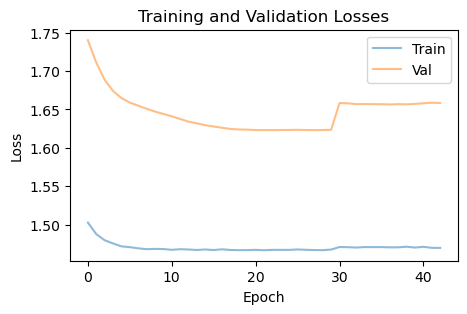

In [ ]:
results_scores, results_train_losses, results_val_losses = runAnalysis(DATASET, costs, n)

## IXITiny

In [11]:
class UNetClassifier(nn.Module):
    def __init__(self):
        super(UNetClassifier, self).__init__()
        self.CHANNELS_DIMENSION = 1
        self.SPATIAL_DIMENSIONS = 2, 3, 4

        self.model = UNet(
            in_channels=1,
            out_classes=2,
            dimensions=3,
            num_encoding_blocks=3,
            out_channels_first_layer=8,
            normalization='batch',
            upsampling_type='linear',
            padding=True,
            activation='PReLU',
        )
        checkpoint = torch.load(f'{ROOT_DIR}/data/IXITiny/whole_images_epoch_5.pth', map_location=torch.device('cpu'))
        self.model.load_state_dict(checkpoint['weights'])

        for name, param in self.named_parameters():
                param.requires_grad = True

    def forward(self, x):
        logits = self.model(x)
        probabilities = F.softmax(logits, dim=self.CHANNELS_DIMENSION)
        return probabilities
    
    def initialize_weights(self):
        if isinstance(self.classifier, nn.Conv3d):
            nn.init.xavier_normal_(self.classifier.weight.data)
            if self.classifier.bias is not None:
                nn.init.constant_(self.classifier.bias.data, 0)

def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(axis=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(axis=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(axis=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score.mean().item()

def get_dice_loss(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return torch.mean(1 - dice_score)

def createModel(n):
    model = UNetClassifier()
    model = model.to(DEVICE)
    criterion = get_dice_loss
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.9)
    return model, criterion, optimizer, lr_scheduler


In [12]:
def loadData(s, dataset, cost):
    sites = {0.08: [['Guys'], ['HH']],
             0.28: [['IOP'], ['Guys']],
             0.30: [['IOP'], ['HH']]}
    site_names = sites[cost][dataset-1]

    image_dir = os.path.join(ROOT_DIR, 'data/IXITiny/image')
    label_dir = os.path.join(ROOT_DIR, 'data/IXITiny/label')
    image_files = []
    label_files = []
    for name in site_names:
            image_files.extend([f'{image_dir}/{file}' for file in os.listdir(image_dir) if name in file])
            label_files.extend([f'{label_dir}/{file}'  for file in os.listdir(label_dir) if name in file])
    image_files, label_files = align_image_label_files(image_files, label_files)
    return np.array(image_files), np.array(label_files)

def get_common_name(full_path):
    return os.path.basename(full_path).split('_')[0]

def align_image_label_files(image_files, label_files):
    labels_dict = {get_common_name(path): path for path in label_files}
    images_dict = {get_common_name(path): path for path in image_files}
    common_keys = sorted(set(labels_dict.keys()) & set(images_dict.keys()))
    sorted_labels = [labels_dict[key] for key in common_keys]
    sorted_images = [images_dict[key] for key in common_keys]
    return sorted_images, sorted_labels

In [13]:
DATA_DIR = f'{ROOT_DIR}/data/IXITiny'
EPOCHS = 100
BATCH_SIZE = 12
RUNS = 10
DATASET = 'IXITiny'
dataset = 'IXITiny'
METRIC_TEST = 'DICE'
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
n = 0
costs = [0.08, 0.28, 0.30]

In [14]:
results_scores, results_train_losses, results_val_losses = runAnalysis(DATASET, costs, n)

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/gpfs/commons/home/aelhussein/anaconda3/envs/cuda_env/lib/python3.9/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


# ISIC

In [9]:
class efficientnetClassifier(nn.Module):
    def __init__(self):
        super(efficientnetClassifier, self).__init__()
        self.efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        for _, param in self.efficientnet.named_parameters():
            param.requires_grad = True
        self.efficientnet.classifier.fc = nn.Linear(1280, 8)

    def forward(self, x):
        logits = self.efficientnet(x)
        return logits

    def initialize_weights(self):
        nn.init.xavier_normal_(self.classifier.weight.data)
        if self.classifier.bias is not None:
            nn.init.constant_(self.classifier.bias.data, 0)

        nn.init.xavier_normal_(self.features.weight.data)
        if self.features.bias is not None:
            nn.init.constant_(self.features.bias.data, 0)

class WeightedFocalLoss(_Loss):
    def __init__(self, alpha=torch.tensor([1, 2, 1, 1, 5, 1, 1, 1]), gamma=2.0):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha.to(torch.float)
        self.gamma = gamma

    def forward(self, inputs, targets):
        targets = targets.view(-1, 1).type_as(inputs)
        logpt = F.log_softmax(inputs, dim=1)
        logpt = logpt.gather(1, targets.long())
        logpt = logpt.view(-1)
        pt = logpt.exp()
        self.alpha = self.alpha.to(targets.device)
        at = self.alpha.gather(0, targets.data.view(-1).long())
        logpt = logpt * at
        loss = -1 * (1 - pt) ** self.gamma * logpt
        return loss.mean()

def createModel(n):
    model = efficientnetClassifier()
    model = model.to(DEVICE)
    criterion = WeightedFocalLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.9)
    return model, criterion, optimizer, lr_scheduler

In [10]:
def loadData(n, dataset, cost):
    dataset_pairings = {0.06: (2,2), 0.15:(2,0), 0.19:(2,3), 0.25:(2,1), 0.3:(1,3)}
    site = dataset_pairings[cost][dataset-1]
    files = pd.read_csv(f'{ROOT_DIR}/data/ISIC/site_{site}_files_used.csv', nrows = 2000)
    image_files = [f'{ROOT_DIR}/data/ISIC/ISIC_2019_Training_Input_preprocessed/{file}.jpg' for file in files['image']]
    labels = files['label'].values
    return np.array(image_files), labels


def get_common_name(full_path):
    return os.path.basename(full_path).split('_')[0]

def align_image_label_files(image_files, label_files):
    labels_dict = {get_common_name(path): path for path in label_files}
    images_dict = {get_common_name(path): path for path in image_files}
    common_keys = sorted(set(labels_dict.keys()) & set(images_dict.keys()))
    sorted_labels = [labels_dict[key] for key in common_keys]
    sorted_images = [images_dict[key] for key in common_keys]
    return sorted_images, sorted_labels

In [11]:
DATA_DIR = f'{ROOT_DIR}/data/ISIC'
EPOCHS = 100
BATCH_SIZE = 32
RUNS = 10
DATASET = 'ISIC'
dataset = 'ISIC'
METRIC_TEST = 'Balanced_accuracy'
LEARNING_RATE = 5e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 0
costs = [0.06, 0.15, 0.19, 0.25, 0.3]

In [12]:
results_scores, results_train_losses, results_val_losses = runAnalysis(DATASET, costs, n)

Using cache found in /gpfs/commons/home/aelhussein/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/gpfs/commons/home/aelhussein/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/gpfs/commons/home/aelhussein/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /gpfs/commons/home/aelhussein/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /gpfs/commons/home/aelhussein/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /gpfs/commons/home/aelhussein/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /gpfs/commons/home/aelhussein